## Optogenetic Two Component System Control Model
This file demonstrates the closed loop simulation (P-control regulation) of the optogenetic two component system

In [1]:
# Import all the modules here 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lmfit

# run_constant is the simulator that runs the open loop experiment
from model_equations_and_simulators.run_constant import run_constant
# run_p_control is the simulator that runs the closed loop experiment with p control
from model_equations_and_simulators.run_p_control import run_p_control


In [2]:
# %%
# Load experimental datasets
data1 = pd.read_csv('experiment_data/P-FL_OD_run_data_042325.csv')
data2 = pd.read_csv('experiment_data/P-FL_OD_run_data_040625.csv')

# Extract experimental replicates
P1_data1 = data1[['SP1_1', 'SP1_2', 'SP1_3', 'SP1_4', 'SP1_5', 'SP1_6']].to_numpy()
P2_data1 = data1[['SP2_1', 'SP2_2', 'SP2_3', 'SP2_4', 'SP2_5', 'SP2_6']].to_numpy()

P1_data2 = data2[['SP1_1', 'SP1_2', 'SP1_3']].to_numpy()
P2_data2 = data2[['SP2_1', 'SP2_2', 'SP2_3']].to_numpy()

green_data1 = data1[['G1']].to_numpy()
green_data2 = data2[['G1', 'G2', 'G3']].to_numpy()
red_data1 = data1[['R1']].to_numpy()
red_data2 = data2[['R1', 'R2', 'R3']].to_numpy()

# Truncate all data to shared minimum length
min_len = min(P1_data1.shape[0], P1_data2.shape[0])
P1_data1 = P1_data1[:min_len]; P2_data1 = P2_data1[:min_len]
P1_data2 = P1_data2[:min_len]; P2_data2 = P2_data2[:min_len]
green_data1 = green_data1[:min_len]; green_data2 = green_data2[:min_len]
red_data1 = red_data1[:min_len]; red_data2 = red_data2[:min_len]


In [3]:
# %%
# Merge all experimental replicates
P1_all = np.hstack((P1_data1, P1_data2))
P2_all = np.hstack((P2_data1, P2_data2))
green_all = np.hstack((green_data1, green_data2))
red_all = np.hstack((red_data1, red_data2))

# Compute means and standard deviations
P1_mean = np.mean(P1_all, axis=1)
P1_std = np.std(P1_all, axis=1)
P2_mean = np.mean(P2_all, axis=1)
P2_std = np.std(P2_all, axis=1)
green_mean = np.mean(green_all, axis=1)
green_std = np.std(green_all, axis=1)
red_mean = np.mean(red_all, axis=1)
red_std = np.std(red_all, axis=1)


In [4]:
# %%
# Time parameters
interval = 10
time = np.arange(interval, (min_len + 1) * interval, interval)
t_final = 16 * 60

# Setpoints from experiments
st_pt_1 = 11500
st_pt_2 = 18500

# Normalize scale using green max
green_max = np.max(green_mean)

# Define color dictionary
color_dict = {
    'set_point_1': '#A06AAF', 
    'set_point_2': '#F29935',
    'green': '#74B867',
    'red': '#D94633'
}


In [5]:
# define model parameters 

p = pd.read_csv('parameters/TCS_model_param_file.csv').to_numpy()
p = p[:,2]

params = lmfit.Parameters()
# defining the parameters using an LMFIT object such that in case of fine
# tuning using LMFIT, the parameter object is ready to use with the appropriate bounds

params.add(name = 'k_green', value = p[0], min = 1e-3, max = 1e4, vary = 1)
params.add(name = 'k_red', value = p[1], min = 1e0, max = 1e4, vary = 1)
params.add(name = 'b_green', value = p[2], min = 1e-4, max = 1e4, vary = 1)
params.add(name = 'b_red', value = p[3], min = 1e0, max = 1e4, vary = 1)

params.add(name = 'k_sp_b', value = p[4], min = 1e-3, max = 1e3, vary = 1)
params.add(name = 'k_sp_u', value = p[5], min = 1e-3, max = 1e3, vary = 1)

params.add(name = 'k_rp_b', value = p[6], min = 1e-3, max = 1e3, vary = 1)
params.add(name = 'k_rp_u', value = p[7], min = 1e-3, max = 1e3, vary = 1)

params.add(name = 'beta', value = p[8], min = 1e-1, max = 200, vary = 1)
params.add(name = 'l0', value = p[9], min = 0, max = 0.5, vary = 1)
params.add(name = 'Kc', value = p[10], min = 1e-3, max = 1e3, vary = 1)
params.add(name = 'd_m', value = p[11], min = 0.05, max = 0.3, vary = 1)
params.add(name = 'k_tl', value = p[12], min = 0.1, max = 5, vary = 1)
params.add(name = 'k_tli_b', value = p[13], min = 1e-3, max = 1e3, vary = 1)
params.add(name = 'k_tli_u', value = p[14], min = 1e-3, max = 1e3, vary = 1)
params.add(name = 'd_p', value = p[15], min = 1e-6, max = 1e-1, vary = 1)
params.add(name = 'k_fold', value = p[16], min = 0.05, max = 0.3, vary = 1)
params.add(name = 'b_fold', value = p[17], min = 0.1, max = 2, vary = 1)
params.add(name = 'n_gamma', value = p[18], min = 0.2, max = 0.9, vary = 1)
params.add(name = 'R_max', value = p[19], min = 1e0, max = 1e4, vary = 1)

params.add(name = 'S_0', value = p[20], min = 1e-3, max = 1e3, vary = 1)
params.add(name = 'R_0', value = p[21], min = 1e-3, max = 1e3, vary = 1)
params.add(name = 'Sp_0', value = p[22], min = 1e-3, max = 1e3, vary = 1)
params.add(name = 'Rp_0', value = p[23], min = 1e-3, max = 1e3, vary = 1)
params.add(name = 'mRNA_0', value = p[24], min = 1e-3, max = 1e3, vary = 1)
params.add(name = 'P_0', value = p[25], min = 1e-3, max = 1e3, vary = 1)
params.add(name = 'Pm_0', value = p[26], min = 1e-3, max = 1e3, vary = 1)


params.add(name = 'k_gr', value = p[27], vary = 0)
params.add(name = 'C_max', value = p[28], vary = 0)
params.add(name = 'C_0', value = p[29], vary = 0)

params.add(name = 'n_tcs', value = p[30], min = 0.1, max = 5, vary = 1)

# define initial conditions and solve the ODEs

x0 = np.zeros(10)

x0[0] = p[20] # S
x0[1] = p[22]# Sp
x0[2] = p[21] # R
x0[3] = p[23] # Rp
x0[4] = 0 # Ac
x0[5] = p[24] # mRNA
x0[6] = 0 # Ctic
x0[7] = p[25] # Unfolded Protein 
x0[8] = p[26] # Folded Protein 
x0[9] = p[29] # Initial Cell count

In [6]:
# Simulate constant inputs
time_green, _, sol_green = run_constant(t_final, x0, params, constant_input = 'green')
time_red, _, sol_red = run_constant(t_final, x0, params, constant_input = 'red')

st_pt_1_model = st_pt_1 * (np.max(sol_green[:,8]))/green_max
st_pt_2_model = st_pt_2 * (np.max(sol_green[:,8]))/green_max

# Simulate p-control 
# Controller gain
gain = 0.063 * (np.max(green_mean)/np.max(sol_green[:,8])) * (1/60) 

# Simulate p-control setpoint 1
t_p1, pctrl_1, time_green_values_1 = run_p_control(t_final, st_pt_1_model, gain, x0, params)
# Simulate p-control setpoint 2
t_p2, pctrl_2, time_green_values_2 = run_p_control(t_final, st_pt_2_model, gain, x0, params)

In [7]:

# Normalize simulation and experimental outputs
green_sim_norm = sol_green[:,8] / np.max(sol_green[:,8])
red_sim_norm = sol_red[:,8] / np.max(sol_green[:,8])
pctrl_1_norm = np.array(pctrl_1) / np.max(sol_green[:,8])
pctrl_2_norm = np.array(pctrl_2) / np.max(sol_green[:,8])
P1_mean_norm = P1_mean / green_max
P1_std_norm = P1_std / green_max
P2_mean_norm = P2_mean / green_max
P2_std_norm = P2_std / green_max
green_mean_norm = green_mean / green_max
green_std_norm = green_std / green_max
red_mean_norm = red_mean / green_max
red_std_norm = red_std / green_max


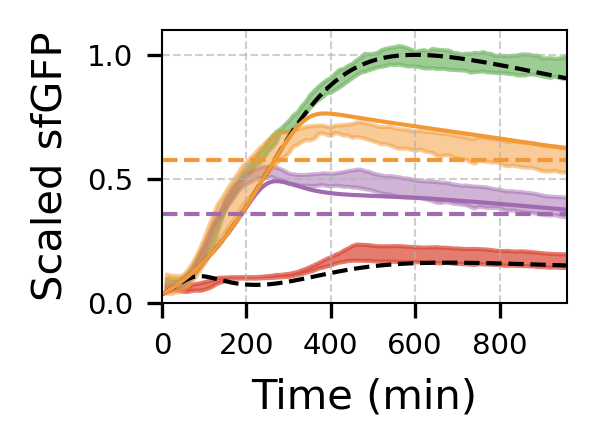

In [8]:
fig, ax = plt.subplots(figsize=(2, 1.5), dpi = 300)

# Style
plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 7,
    'axes.labelsize': 7,
    'axes.titlesize': 7,
    'legend.fontsize': 6
})
tick_fontsize = 7

# Line width and alpha
lwd = 1
alp = 0.5

# Model predictions
ax.plot(time_green, green_sim_norm, color = 'k', linestyle='--', linewidth=lwd, label='Const. Green')
ax.plot(time_red, red_sim_norm, color = 'k', linestyle='--', linewidth=lwd, label='Const. Red')
ax.plot(t_p1, pctrl_1_norm, color=color_dict['set_point_1'], linestyle='-', linewidth=lwd, label='SP1 Tracking')
ax.plot(t_p2, pctrl_2_norm, color=color_dict['set_point_2'], linestyle='-', linewidth=lwd, label='SP2 Tracking')

# Experimental shaded regions
ax.fill_between(time, green_mean_norm - green_std_norm,
                green_mean_norm + green_std_norm, color = color_dict['green'], alpha=0.7)

ax.fill_between(time, red_mean_norm - red_std_norm,
                red_mean_norm + red_std_norm, color = color_dict['red'], alpha=0.7)

ax.fill_between(time, P1_mean_norm - P1_std_norm,
                P1_mean_norm + P1_std_norm, color=color_dict['set_point_1'], alpha=alp)

ax.fill_between(time, P2_mean_norm - P2_std_norm,
                P2_mean_norm + P2_std_norm, color=color_dict['set_point_2'], alpha=alp)

# Horizontal set points
ax.axhline(y=st_pt_1 / green_max, color=color_dict['set_point_1'], linestyle='--', linewidth=lwd)
ax.axhline(y=st_pt_2 / green_max, color=color_dict['set_point_2'], linestyle='--', linewidth=lwd)

# Axes
ax.set_xlabel('Time (min)')
ax.set_ylabel('Scaled sfGFP')
ax.set_xlim(0, 960)
ax.set_ylim(0, 1.1)
ax.set_xticks([0, 200, 400, 600, 800])
ax.set_yticks([0, 0.5, 1.0])

# # Legend
# leg = ax.legend(loc='lower center', bbox_to_anchor=(1.02, -0.5), frameon = False, ncol = 4)
# # set the linewidth of each legend object
# for legobj in leg.legendHandles:
#     legobj.set_linewidth(1)

# Spine control
spine_width = 0.5
for spine in ['top', 'right', 'bottom', 'left']:
    ax.spines[spine].set_visible(True)
    ax.spines[spine].set_linewidth(spine_width)

# Ticks
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)

# Grid
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)

# Layout
fig.subplots_adjust(right=0.75)
plt.tight_layout()

# Save (if needed)
#plt.savefig('figures/d. p_control_model.svg', format='svg', dpi=300, bbox_inches='tight', transparent=True)

In [9]:
# # Scaled P control data export utility

# p_ctrl_data = dict()

# time_data_points = np.linspace(0, t_final, t_final) # Time points for the data to be interpolated to to ensure consistent size of arrays
# p_ctrl_data['Set point 1'] = np.interp(time_data_points, t_p1, pctrl_1_norm)
# p_ctrl_data['Set point 2'] = np.interp(time_data_points, t_p2, pctrl_2_norm)
# p_ctrl_data['Constant Green'] = np.interp(time_data_points, time_green, green_sim_norm)
# p_ctrl_data['Constant Red'] = np.interp(time_data_points, time_red, red_sim_norm)

# p_ctrl_data['Time (min)'] = time_data_points

# p_ctrl_df = pd.DataFrame(data = p_ctrl_data)
# p_ctrl_df.to_csv('P_control_simulation_data.csv')